# Optimization and Solving Systems of Equations in Julia
This notebook is based on [Patrick Mogensen's tutorial on JuliaCon 2017](https://www.youtube.com/embed/E_UlaGoObTw).

In [1]:
display("text/html", 
        "<div align='center'>
        <iframe width='640' height='360'
            src='https://www.youtube.com/embed/E_UlaGoObTw'>
        </iframe>
        </div>")

## Content
- I Optimization
    - Optimization in a Nutshell
    - JuliaNLSolvers: Optim.jl
    - Optim.jl: syntax and examples
    - LsqFit.jl: optimization and curve fitting
    - Outside of JNLS
- II Curve Fitting
    - JuliaNLSolvers: LsqFit.jl
- III Solving (systems of) equations
    - The problem
    - JuliaNLSolvers: NLsolve.jl

## Optimization in a nutshell
Optimization is a lot of things, but for the purpose of this workshop:

$$
\begin{align}
&\text{minimize }&&f_0(x)\\
   &\text{subject to }~&&f_i(x) \leq 0,~i = 1..n\\
    &{} &&h_j(x) =  0,~j = 1..m
    \end{align}
$$

Where $f_0$ is the objective, $f_i$'s for $i>0$ are the inequality constraints and $h_i$'s are the equality constrains.

Topics: unconstrained, convex (linear, quadratic, ...), polynomial, and so on.

Many classes of problems exist, but today we will look at what is often called nonlinear programming or optimization, even if many other classes are also nonlinear.

### Unconstrained Optimization
Unconstrained optimization refers to the case with no $f_i$ or $h_i$ constraints.

Now, what is our job then? Find an $x$ such that for all $x'
\in\mathbf{dom }~f$ we have that

$$
f(x)\leq f(x')
$$

$x$ is then called a global minimizer and $f(x)$ is called the global minimum.

#### Example: Unconstrained Optimization
Unconstrained optimization refers to the case where $f_i(x)=0$ for all $i\in\{1,\ldots,n\}$ and $h_i(x)=0$ for all $j\in\{1\ldots,m\}$.

Now, what is our job then? Find an $x$ such that for all $x'
\in\mathbf{dom } f$ we have that

$$
f(x)\leq f(x')
$$

Of course, this is trivial here, because $f(x)$ is convex, so if we find and $x$ such that the condition holds only locally, then we've found the global solution as well.

### Univariate case

#### Quadratic


$$
\begin{align}
f_0(x)=f(x)=x^2
\end{align}
$$

Minima, global minimum, minimizers?

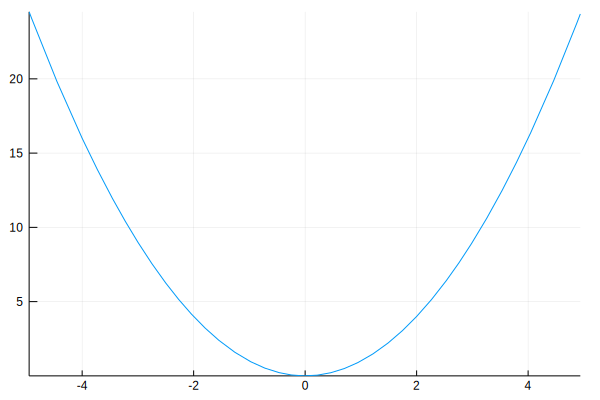

In [2]:
using Plots
gr()
plot(x->x^2; legend=false)

#### A trigonometric function

$$
f(x) = sin(x)
$$

Minima, global minimum, minimizers?

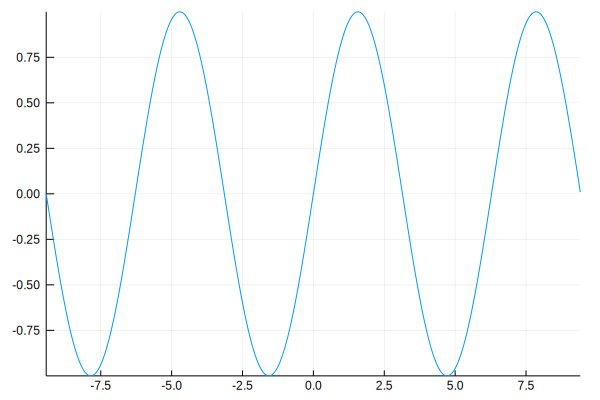

In [3]:
plot((-3π:0.01:3π),x->sin(x);legend=false)

### Wave, wave, wave, ...
$$
f(x) = sin(x)/x
$$

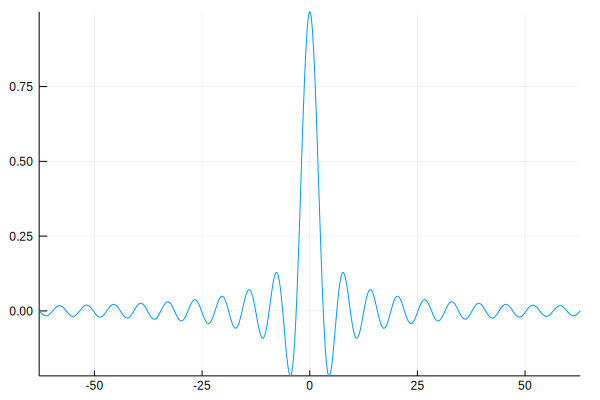

In [4]:
plot((-20π:0.01:20π),x->sin(x)/x;legend=false)

### Multivariate
Moving to multivariate function, we could consider the so called Rosenbrock test function.
$$
f({\mathbf  {x}})=f(x_{1},x_{2},\dots ,x_{N})=\sum _{{i=1}}^{{N/2}}\left[100(x_{{2i-1}}^{2}-x_{{2i}})^{2}+(x_{{2i-1}}-1)^{2}\right]
$$
or in two dimensions
$$
f({\mathbf  {x}})=f(x_{1},x_{2})= (1-x_1^2+100(x_2-x_1^2))^2
$$
or in code

In [5]:
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2

rosenbrock (generic function with 1 method)

In [6]:
x1 = x2 = -3:0.01:3
contour(x1, x2, (x1, x2)->(1.0 - x1)^2 + 100.0 * (x2 - x1^2)^2,fill=false, color=:deep, legend=false, levels=300)

## I Optimization
Basically, we support

- Derivative-free (heuristics)
- First order (uses the gradient)
- Second order (uses the gradient *and* Hessian)

for multivariate unconstrained or box constrained minimization. For constrained univariate optimization, we also have two derivative free methods.

### Derivative-free methods
These methods are all heuristics that might do a pretty good job at finding a point $x$ that makes $f(x)$ small, using only $f$ and some set of rules for trying different $x$'s

### First order methods
These use the gradient to find a search direction from a given iterate, and possibly given the history of iterates. For differentiable problems, they can be a lot faster and more accurate than the above.

### Second order methods
These use the Hessian in a addition to the gradient to exploit local curvature when choosing a search direction. If the Hessian is available, and is not too large, these methods are very powerful.

### Case study: Nelder-Mead

Maintain a simplex (n-d "triangle" of points). Taking a step then amounts to trying to replace the worst point with a new point by: reflecting, expanding, contracting, or shrinking.

### Case study: Gradient Descent
Probably one of the simplest approaches to minimizing a differentiable function is to use gradient descent. The idea here is simply to choose a search direction
$$
s^k = -\nabla f(x^k)
$$
with a final step of
$$
x^{k+1} = x^k+\alpha s
$$
![source: https://en.wikipedia.org/wiki/Gradient_descent#/media/File:Gradient_descent.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Gradient_descent.svg/448px-Gradient_descent.svg.png)

### Case study: Newton's method
The Holy Grail, the Gold Standard, and what all other methods want to be: Newton's method. We incorporate the curvature by replacing the gradient descent steps with

$$
    s = -H(x^k)^{-1}\nabla f(x^k)
$$

and then 

$$
    x^{k+1} = x^k+\alpha s
$$

### Interpretation: (Quasi-)Newton solvers
Above we saw a univariate quadratic function. Consider instead the multivariate quadratic problem

$$
\text{minimize}~r+q^\top x+(1/2)x^\top P x
$$

the so-called first order conditions are obtained by calculating the gradient $\nabla f(x)$ of the function, and solving the problem $\nabla f(x) = 0$. If $P\succ 0$, we can solve this problem by calculating
$$
x_{opt} = -P^{-1}q
$$

the fact that we can solve the first order conditions **analytically** is a very big deal, and can be seen as the basis for all the methods we might call quasi-Newton methods. They do so by forming quadratic function approximations to our function $f(x)$ around a point $x_0$

$$
\text{minimize}~\tilde{f}(x_0+s) = f(x_0) + \nabla f(x_0)^\top s + (1/2)s^\top P s
$$

with solution
$$
s = -P^{-1}\nabla f(x_0)
$$
We call this the search direction. 

We introduce a step-length $\alpha$, such that the final updating rule for $x$ is
$$
x_{next} = x_{current} +\alpha s
$$

## JuliaNLSolvers: Optim.jl
### Set up the package
To make sure everything is working and is up to date (if you dare), run.

In [7]:
#Pkg.add("Optim")
#Pkg.update() # I'm too scared to break anything
using Optim

### Syntax
To optimize (minimize) a function, you have to provide, *at the very least*, a function to calculate the objective and a starting point.
```julia
optimize(objective args..., initial_x, [method], [options])
```
some examples...

$$
\text{minimize}~x^\top x
$$

In [8]:
obj(x) = sum(x->x^2, x) # equals to obj(x) = sum(x.^2) = x.'x
x0 = rand(30)
optimize(obj, x0) # defaut option is optimize(obj, x0, NelderMead(), Optim.Options())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.5682773518875641,0.42459695992313806, ...]
 * Minimizer: [0.07823834123392999,0.07246531444690213, ...]
 * Minimum: 8.394346e-01
 * Iterations: 1000
 * Convergence: false
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1235

that didn't go too well... let's try to add gradient information to the mix

$$
g(x) = \nabla x^\top x 
= \begin{bmatrix}
\frac{\partial x^\top x}{\partial x_0}\\ 
\vdots \\ 
\frac{\partial x^\top x}{\partial x_n}
\end{bmatrix} 
= 2x
$$

In [9]:
obj(x) = sum(x->x^2, x) # equals to obj(x) = sum(x.^2) = sum(x.^2) = x.'x
g!(g, x) = copy!(g, 2.0*x) # g is a vector storing gradient (inplace update)
x0 = rand(30)
optimize(obj, g!, x0, GradientDescent()) 

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.690198930394964,0.7466500601481663, ...]
 * Minimizer: [0.0,0.0, ...]
 * Minimum: 0.000000e+00
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 9.93e-01 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = Inf |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 0.00e+00 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3
 * Gradient Calls: 3

In [10]:
x0 = rand(30)
optimize(obj, g!, x0, GradientDescent(linesearch=LineSearches.Static())) # Static version does't do well

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.3510079066158369,0.18816448624099835, ...]
 * Minimizer: [-0.3510079066158369,-0.18816448624099835, ...]
 * Minimum: 1.056300e+01
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.98e+00 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.98e+00 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 2
 * Gradient Calls: 2

In [11]:
x0 = rand(30)
optimize(obj, g!, x0, LBFGS()) # (L-)BFGS method will try to approaximate Hessian matrix

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.1274671279819961,0.7697537392558558, ...]
 * Minimizer: [0.0,0.0, ...]
 * Minimum: 0.000000e+00
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 9.89e-01 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = Inf |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 0.00e+00 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3
 * Gradient Calls: 3

That did the trick! One iteration when using a line search algorithm to find $\alpha$.

Remember the Rosenbrock function from earlier. We have access to the objective, gradient and Hessian from the collection of unconstrained problems in Optim.

In [12]:
# Pkg.add("OptimTestProblems")
using OptimTestProblems # Test problems for JuliaNLSolvers packages

In [13]:
prob = MultivariateProblems.UnconstrainedProblems.examples["Rosenbrock"]
rosf = prob.f
rosg! = prob.g!
rosh! = prob.h!

rosenbrock_hessian! (generic function with 1 method)

Then let's try the wonderful GradientDescent method from earlier... one iteration was needed last time, soo...

In [14]:
optimize(rosf, rosg!, [-3.0, -4.0], GradientDescent())

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [-3.0,-4.0]
 * Minimizer: [0.9177411054737754,0.8420768198591049]
 * Minimum: 6.769481e-03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.33e-04 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 2.10e-03 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.01e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2541
 * Gradient Calls: 2541

In [15]:
optimize(rosf, rosg!, [-1.0, 1.0], GradientDescent())

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [-1.0,1.0]
 * Minimizer: [0.9549034847402014,0.9116205490197754]
 * Minimum: 2.038541e-03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.48e-04 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 4.51e-03 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.40e-02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2574
 * Gradient Calls: 2574




**So sad...**
what about something that doesn't even use the local information?

In [16]:
optimize(rosf, [-3.0, -4.0], NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-3.0,-4.0]
 * Minimizer: [1.0000163422225956,1.0000406149799987]
 * Minimum: 6.555983e-09
 * Iterations: 78
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 151

That helped... What about using more information?

In [17]:
optimize(rosf, rosg!, rosh!, [-3.0, -4.0], Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [-3.0,-4.0]
 * Minimizer: [0.9999999999445034,0.9999999998967297]
 * Minimum: 9.044243e-21
 * Iterations: 29
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.84e-05 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 3.18e+10 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.20e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 84
 * Gradient Calls: 84
 * Hessian Calls: 29

### A knife edge case
$$
f(x) = \frac{1}{2} x_1^2 + \frac{1}{4}x_1^4-\frac{1}{2}x_1^2 \Rightarrow \nabla f(x) = \binom{x_1}{x_2(x_2^2-1)}
$$
start at $x_0=(x_{1,0},x_{2,0})=(\bar{x}, 0)$ for $x_0\in\text{dom }f$

How will Gradient Descent fare? Newton? BFGS?

In [18]:
contour(-2:0.01:2, -2:0.01:2, (x,y)->x^2/2+y^4/4-y^2/2, color=:deep,  fill=false,legend=false, levels=300, xlabel="x", ylabel="y")

Lesson? Don't blame Optim!

### Missing gradients or Hessians
... but differentiable problem! You can prove it, but you just don't have the patience or skills (but really patience) to calculate it.

Use finite differences from Calculus.jl or automatic differentiation ForwardDiff.jl. 

In [19]:
optimize(rosf, rosg!, rosh!, [-1.0,-1.0], Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [-1.0,-1.0]
 * Minimizer: [0.9999999999990292,0.9999999999980881]
 * Minimum: 1.030282e-24
 * Iterations: 21
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.04e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.93e+11 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.38e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 62
 * Gradient Calls: 62
 * Hessian Calls: 21

In [20]:
td = TwiceDifferentiable(rosf, [-1.0, -1.0], autodiff = :forward)
optimize(td, [-1.0,-1.0], Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [-1.0,-1.0]
 * Minimizer: [0.9999999999990292,0.9999999999980881]
 * Minimum: 1.030282e-24
 * Iterations: 21
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.04e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.93e+11 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.38e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 62
 * Gradient Calls: 62
 * Hessian Calls: 21

In [21]:
optimize(rosf, [-1.0,-1.0], Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [-1.0,-1.0]
 * Minimizer: [0.999999992665655,0.9999999853313382]
 * Minimum: 5.379262e-17
 * Iterations: 21
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.68e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.72e+03 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.25e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 62
 * Gradient Calls: 62
 * Hessian Calls: 21

### Options

There are two types of options to set in Optim. Either directly related to the solver or more generally for the behaviour of `optimize`

Options for solvers control tuning parameters and choice of line search

In [22]:
method = Newton(linesearch=LineSearches.MoreThuente())

Optim.Newton{LineSearches.InitialStatic{Float64},LineSearches.MoreThuente{Float64}}(LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.MoreThuente{Float64}
  f_tol: Float64 0.0001
  gtol: Float64 0.9
  x_tol: Float64 1.0e-8
  stpmin: Float64 1.0e-16
  stpmax: Float64 65536.0
  maxfev: Int64 100
)

Choice of line searches in LineSearches are
 - `MoreThuente`
 - `HagerZhang`
 - `Backtracking` (quadratic or cubic depending on `order=[2|3]` keyword)
 - `StrongWolfe`
 - `Static` (think learning parameter)

Options more generally for `optimize` are set by passing `Optim.Options()` as the last argument to `optimize`

In [23]:
obj(x) = sum(x->x^2, x)
x0 = rand(30)
optimize(obj, x0, Optim.Options(iterations=1000))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.020457719940778496,0.40504756154716604, ...]
 * Minimizer: [0.20463101152972626,0.049714647654066954, ...]
 * Minimum: 4.288306e-01
 * Iterations: 1000
 * Convergence: false
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1271

### Traces

To analyze the path from the starting point to the final iterate we can look at the trace. There are three variants here:

- store_trace
- show_trace
- extended_trace

The last one only has an effect if at least one of the two first are `true`.

In [24]:
prob = UnconstrainedProblems.examples["Hosaki"]
optimize(prob.f, prob.initial_x, Optim.Options(show_trace=true))

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0    -2.134718e+00     2.877686e+00
     1    -2.134718e+00     4.391230e-01
     2    -2.134718e+00     1.897094e-01
     3    -2.302859e+00     7.395993e-02
     4    -2.302859e+00     1.070066e-02
     5    -2.302859e+00     1.941580e-02
     6    -2.332442e+00     1.334611e-02
     7    -2.332442e+00     3.829389e-03
     8    -2.338839e+00     5.071918e-03
     9    -2.344864e+00     2.649378e-03
    10    -2.344864e+00     3.789623e-04
    11    -2.344864e+00     4.675731e-04
    12    -2.345603e+00     3.396260e-04
    13    -2.345603e+00     5.023483e-05
    14    -2.345684e+00     6.205956e-05
    15    -2.345755e+00     4.383005e-05
    16    -2.345789e+00     1.611077e-05
    17    -2.345789e+00     1.789610e-06
    18    -2.345793e+00     9.116789e-06
    19    -2.345810e+00     7.710923e-06
    20    -2.345810e+00     1.398459e-06
    21    -2.345810e+00     1.177440e-06
    22    -2.

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.6,1.9]
 * Minimizer: [4.000056296115236,2.000103877026219]
 * Minimum: -2.345812e+00
 * Iterations: 28
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 59

In [25]:
optimize(prob.f, prob.g!, prob.initial_x, Optim.Options(show_trace=true))

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0    -2.134718e+00     2.877686e+00
     1    -2.134718e+00     4.391230e-01
     2    -2.134718e+00     1.897094e-01
     3    -2.302859e+00     7.395993e-02
     4    -2.302859e+00     1.070066e-02
     5    -2.302859e+00     1.941580e-02
     6    -2.332442e+00     1.334611e-02
     7    -2.332442e+00     3.829389e-03
     8    -2.338839e+00     5.071918e-03
     9    -2.344864e+00     2.649378e-03
    10    -2.344864e+00     3.789623e-04
    11    -2.344864e+00     4.675731e-04
    12    -2.345603e+00     3.396260e-04
    13    -2.345603e+00     5.023483e-05
    14    -2.345684e+00     6.205956e-05
    15    -2.345755e+00     4.383005e-05
    16    -2.345789e+00     1.611077e-05
    17    -2.345789e+00     1.789610e-06
    18    -2.345793e+00     9.116789e-06
    19    -2.345810e+00     7.710923e-06
    20    -2.345810e+00     1.398459e-06
    21    -2.345810e+00     1.177440e-06
    22    -2.

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.6,1.9]
 * Minimizer: [4.000056296115236,2.000103877026219]
 * Minimum: -2.345812e+00
 * Iterations: 28
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 59

In [26]:
optimize(prob.f, prob.initial_x, Optim.Options(show_trace=true, extended_trace=true))

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0    -2.134718e+00     2.877686e+00
 * step_type: initial
 * centroid: [3.6, 2.3875]
     1    -2.134718e+00     4.391230e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     2    -2.134718e+00     1.897094e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     3    -2.302859e+00     7.395993e-02
 * step_type: outside contraction
 * centroid: [3.82813, 2.08281]
     4    -2.302859e+00     1.070066e-02
 * step_type: inside contraction
 * centroid: [3.99922, 1.97617]
     5    -2.302859e+00     1.941580e-02
 * step_type: inside contraction
 * centroid: [3.92793, 2.10186]
     6    -2.332442e+00     1.334611e-02
 * step_type: inside contraction
 * centroid: [3.99565, 2.07996]
     7    -2.332442e+00     3.829389e-03
 * step_type: inside contraction
 * centroid: [3.91635, 1.95165]
     8    -2.338839e+00     5.071918e-03
 * step_type: reflection
 * centroid: [3.96068, 2

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.6,1.9]
 * Minimizer: [4.000056296115236,2.000103877026219]
 * Minimum: -2.345812e+00
 * Iterations: 28
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 59

In [27]:
optimize(prob.f, prob.g!, prob.initial_x, Optim.Options(show_trace=true, extended_trace=true))

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0    -2.134718e+00     2.877686e+00
 * step_type: initial
 * centroid: [3.6, 2.3875]
     1    -2.134718e+00     4.391230e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     2    -2.134718e+00     1.897094e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     3    -2.302859e+00     7.395993e-02
 * step_type: outside contraction
 * centroid: [3.82813, 2.08281]
     4    -2.302859e+00     1.070066e-02
 * step_type: inside contraction
 * centroid: [3.99922, 1.97617]
     5    -2.302859e+00     1.941580e-02
 * step_type: inside contraction
 * centroid: [3.92793, 2.10186]
     6    -2.332442e+00     1.334611e-02
 * step_type: inside contraction
 * centroid: [3.99565, 2.07996]
     7    -2.332442e+00     3.829389e-03
 * step_type: inside contraction
 * centroid: [3.91635, 1.95165]
     8    -2.338839e+00     5.071918e-03
 * step_type: reflection
 * centroid: [3.96068, 2

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.6,1.9]
 * Minimizer: [4.000056296115236,2.000103877026219]
 * Minimum: -2.345812e+00
 * Iterations: 28
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 59

In [28]:
optimize(prob.f, prob.g!, prob.h!, prob.initial_x, Optim.Options(show_trace=true,extended_trace=true))

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0    -2.134718e+00     2.877686e+00
 * step_type: initial
 * centroid: [3.6, 2.3875]
     1    -2.134718e+00     4.391230e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     2    -2.134718e+00     1.897094e-01
 * step_type: outside contraction
 * centroid: [3.6, 2.3875]
     3    -2.302859e+00     7.395993e-02
 * step_type: outside contraction
 * centroid: [3.82813, 2.08281]
     4    -2.302859e+00     1.070066e-02
 * step_type: inside contraction
 * centroid: [3.99922, 1.97617]
     5    -2.302859e+00     1.941580e-02
 * step_type: inside contraction
 * centroid: [3.92793, 2.10186]
     6    -2.332442e+00     1.334611e-02
 * step_type: inside contraction
 * centroid: [3.99565, 2.07996]
     7    -2.332442e+00     3.829389e-03
 * step_type: inside contraction
 * centroid: [3.91635, 1.95165]
     8    -2.338839e+00     5.071918e-03
 * step_type: reflection
 * centroid: [3.96068, 2

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.6,1.9]
 * Minimizer: [4.000056296115236,2.000103877026219]
 * Minimum: -2.345812e+00
 * Iterations: 28
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 59

If the trace is stored, use `Optim.trace(res)` to grab the trace

In [29]:
res = optimize(prob.f, prob.g!, prob.h!, prob.initial_x, Optim.Options(store_trace=true))
res_trace = Optim.trace(res) 

29-element Array{Optim.OptimizationState{Float64,Optim.NelderMead{Optim.AffineSimplexer,Optim.AdaptiveParameters}},1}:
      0    -2.134718e+00     2.877686e+00

      1    -2.134718e+00     4.391230e-01

      2    -2.134718e+00     1.897094e-01

      3    -2.302859e+00     7.395993e-02

      4    -2.302859e+00     1.070066e-02

      5    -2.302859e+00     1.941580e-02

      6    -2.332442e+00     1.334611e-02

      7    -2.332442e+00     3.829389e-03

      8    -2.338839e+00     5.071918e-03

      9    -2.344864e+00     2.649378e-03

     10    -2.344864e+00     3.789623e-04

     11    -2.344864e+00     4.675731e-04

     12    -2.345603e+00     3.396260e-04

 ⋮                                        
     17    -2.345789e+00     1.789610e-06

     18    -2.345793e+00     9.116789e-06

     19    -2.345810e+00     7.710923e-06

     20    -2.345810e+00     1.398459e-06

     21    -2.345810e+00     1.177440e-06

     22    -2.345810e+00     2.933154e-07

     23    -2.345811e

### Results grabbing API
As we saw above, there are functions for grabbing information store in the output.

Use `Optim.minimizer(res)` instead of `res.minimizer` to allow deprecations from our side!

They are listed in the documentation, but the names should be somewhat self-explanatory:
- `minimizer`
- `minimum`
- `iterations`
- `trace`
- `g_calls`
- etc

### Univariate optimization
Univariate functions can be optimized with many of the methods from the multivariate toolbox, as long as the argument is passed as a one element array.

```
    optimize(f, [g!], initial_x, [method], [options])
```

In [30]:
# Problem 18 from http://infinity77.net/global_optimization/test_functions_1d.html
uniprob = UnivariateProblems.examples["Problem13"]

OptimTestProblems.UnivariateProblems.UnivariateProblem("Problem13", OptimTestProblems.UnivariateProblems.p13, [0.001, 0.99], [0.707107], [-1.5874])

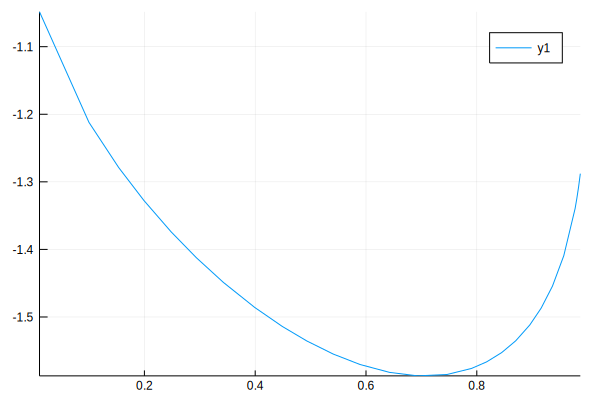

In [31]:
unif = uniprob.f
plot(unif, uniprob.bounds...)

In [32]:
optimize(x->unif(x[1]), [mean(uniprob.bounds)], AcceleratedGradientDescent())

Results of Optimization Algorithm
 * Algorithm: Accelerated Gradient Descent
 * Starting Point: [0.4955]
 * Minimizer: [0.7070331313852414]
 * Minimum: -1.587401e+00
 * Iterations: 3
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.04e-02 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = -9.59e-05 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.98e-02 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 11
 * Gradient Calls: 11

Or we could use one of the two specialized methods for univariate optimization. The syntax is

```
optimize(f, lower_bound, upper_bound, [method], [kwargs...])
```

In [33]:
optimize(unif, uniprob.bounds...)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.001000, 0.990000]
 * Minimizer: 7.071068e-01
 * Minimum: -1.587401e+00
 * Iterations: 10
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 11

### Taking advantage of Julia's type system
Univariate optimization allows for us to pass a DualNumber and thus use ForwardDiff to calculate the derivative of the minimum as a function of some auxilirary variables. This should be coming for multivariate optimization soon.

Say we need to solve some equation $G(y)=0$ where evaluating $G(y)$ requires us to solve an optimization problem
$$
    \text{minimize}_x~f(x,y)
$$
If we need to evaluate the derivative of $G(y)$ we then need to know the derivative of the minimum of the nested problem.

Consider the function

$$
f(x,y) = x^2+xy^2
$$

with minimizer $x^* = -y^2/4$ and minimum $f^*(y)=-y^4/4$. Then we have that $\frac{df^*}{dy}(y)=-y^3$. For $y=1.1$ this means that $\frac{df^*}{dy}(1.1)=-1.331$.

But we can also use Optim.jl and ForwardDiff to get to this

In [34]:
dualf(x,y) = x[1]^2+x*y[1]^2
dualg(param) = Optim.minimum(optimize(x->dualf(x,param), -1,1))
ForwardDiff.gradient(dualg, [1.1])

1-element Array{Float64,1}:
 -1.331

### Outside of JNLS
Several packages exist in Julia that can be used. Most notably, there's a Julia wrapper for the well-known and high quality NLOpt package called... NLOpt.jl.

NLOpt has many solvers available
 - Global optimization
 - Derivative free (Local)
 - Gradient based (Local)
 - Augmented Lagrangian
 
 Especially the first and the constrained optimizers are interesting to us, given Optim.jl's current coverage.

### Nonlinear Least Squares Optimization

#### The problem
We have an objective, but it's a special type of objective in that it has the form
$$
 f(x)=\sum_{i=1}^m r_i^2
$$
where $r_i$ is the i'th *residual* given by
$$
r_i = y_i-m(p, x_i)
$$
where $m$ is the so-called model or curve function, $y_i$ is the function value we fit to and $x_i$ are the variables and $p$ is the parameter vector (notice the change of notation!).

Such a problem is often motivated by a setup where we observe the model with noise.
$$
y_{i}^{obs} = m(p, x_i^{obs})+noise
$$

## II Curve Fitting

### Example: An exponential model
Say we have a model of the form
$$
   m(x, p) = p_1\exp(p_2x)
$$
that is univariate in $x$. Let us try to plot the function on the interval $[0:10]$, and add some randomly generated data.

In [35]:
# x: array of independent variables
# p: array of model parameters
model(x, p) = p[1]*exp.(-x.*p[2])

# some example data
# xdata: independent variables
# ydata: dependent variable
xdata = linspace(0,10,20)
ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))

20-element Array{Float64,1}:
  0.998311  
  0.347792  
  0.125711  
  0.0305273 
  0.00771411
  0.0122475 
  0.0165188 
 -0.0155856 
 -0.0209519 
 -0.00101352
 -0.0110516 
 -0.0152966 
 -0.0158319 
 -0.0200146 
  0.00137868
 -0.0226266 
 -0.00836834
  0.00983975
  0.0119242 
  0.0102672 

Choice of method matters!

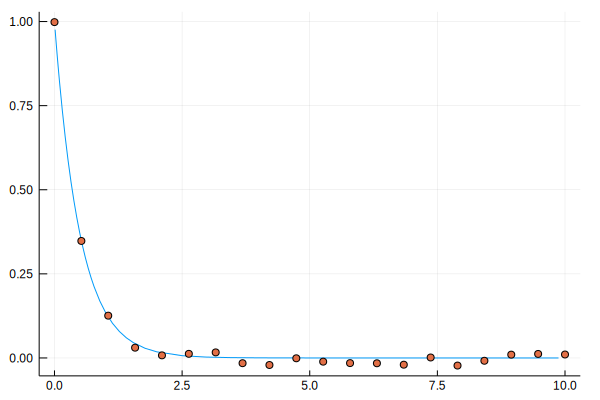

In [36]:
plot(x->1*exp(-2*x), 0,10, legend=false); scatter!(xdata, ydata)

## JuliaNLSolvers: LsqFit.jl
The syntax is very simple. We *need* to provide a model, some data, and a starting value. We *can* provide a Jacobian, lower and upper bounds, and weights.

In [37]:
# Pkg.add("LsqFit")
using LsqFit
p0 = [0.5, 0.5]
fit = curve_fit(model, xdata, ydata, p0)

LsqFit.LsqFitResult{Float64,1}(18, [0.998743, 2.00941], [0.00043243, -0.000934876, -0.00524983, 0.0113081, 0.00681509, -0.00720156, -0.0147664, 0.0161942, 0.0211632, 0.00108692, 0.0110771, 0.0153055, 0.0158349, 0.0200156, -0.00137831, 0.0226267, 0.00836838, -0.00983973, -0.0119242, -0.0102672], [1.0 0.0; 0.347294 -0.182556; … ; 5.40188e-9 -5.11114e-8; 1.87611e-9 -1.87368e-8], true, Float64[])

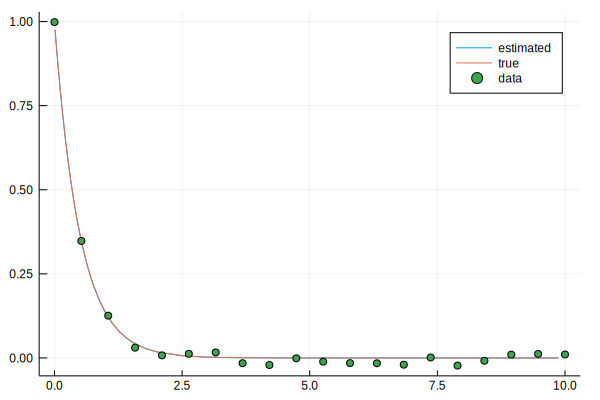

In [38]:
plot(x->fit.param[1]*exp.(-x.*fit.param[2]), 0, 10, lab = "estimated")
plot!(x->1*exp(-2*x), 0,10, lab = "true")
scatter!(xdata, ydata, lab = "data")

### Example: waves, waves, waves (continued)

Earlier we looked a function similar to
$$ 
f(t) = sin(5.1*t)/t
$$

Imagine we observe such a signal (or more) where t is time from time 0. The problem is, our measuring equipment fired off at irregular intervals and it's rather cheap so the recorded signals are noisy.

In [39]:
model(x, p) = sin.(p[1]*x)./x
xdata = rand(50)*10. # random uniform from 0 to 10
ydata = model(xdata, [5.1,]) + 0.01*randn(length(xdata))
fit = curve_fit(model, xdata, ydata, [0.3,])

LsqFit.LsqFitResult{Float64,1}(49, [1.67272], [0.417043, -0.270173, 0.0427587, 0.0764009, 0.100524, -0.0336906, 0.175144, 0.125386, 0.111816, -0.281934  …  0.209361, 0.0785234, 0.0802497, 0.0455161, 0.226662, 0.0524436, 0.00186944, 0.409849, 1.48419, 0.0155664], [0.146514; -0.933074; … ; 0.494493; -0.964121], true, Float64[])

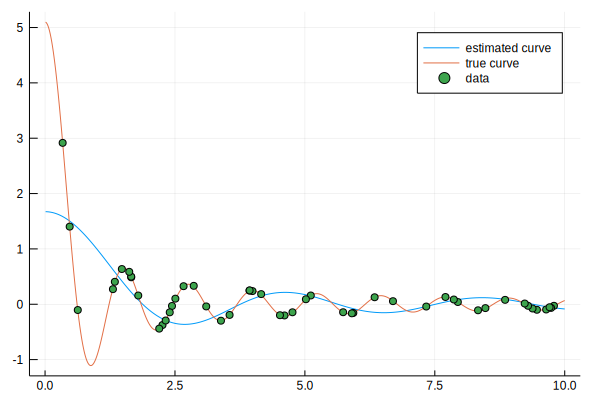

In [40]:
plot((0.0:0.01:10.0),  x->model(x, fit.param), label= "estimated curve")
plot!((0.0:0.01:10.0),  x->model(x, [5.1,]), label= "true curve")
scatter!(xdata, ydata, label="data")

# Solving Systems of Equations

Consider the following problem of finding an $x$ such that
$$
\begin{align}
f_1(x) &= 0\\
f_2(x) &= 0\\
&\vdots\\
f_N(x) &= 0
\end{align}
$$
where $x$ is in some subset of $\mathbb{R}^N$. We write $F(x)=0$ for short. 

### Example: fixed points
A special type of problems are fixed point problems
$$
F(x) = x
$$
but these can obviously be solved by the same methods by setting $\tilde{F}(x)=F(x)-x$ to zero.

We are going to use methods much like above, but there is no objective this time! We just need a zero/solution.

Without going into too much details, you can think of these methods much like the second order methods from above, although we have no "objective function". At each iteration, we choose a direction

$$
s = J(x)^{-1}F(x)
$$

where $J(x)$ is the Jacobian of $F(x)$, and then we either choose a step size based on a line search (by use of a merit function) or a trust region approach.

Syntax is straight forward

```
   nlsolve(F, [J], initial_x; kwargs...)
```
where F fills a vector with the results of the $f_i$'s and $J$ fills the associated Jacobian

### Example: Rosenbrock FOCs as a system of nonlinear equation
Let's try solving a system of equations that happen to have the same form as the FOCs for minimizing the Rosenbrock function.

In [41]:
# Pkg.add("NLsolve")
using NLsolve

In [42]:
prob = UnconstrainedProblems.examples["Rosenbrock"]
nlsolve((g,x)-> prob.g!(g, x), prob.initial_x) # order of arguments...

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-1.2, 1.0]
 * Zero: [-4.93942, 24.4039]
 * Inf-norm of residuals: 1.188616
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 1001
 * Jacobian Calls (df/dx): 715

### Example: Butt-cheek function

Consider the following system of equations
$$
    \begin{align}
    x &= 0\\
    y(y^2-1)&=0
    \end{align}
$$
The first condition is trivial. How does the second one look?

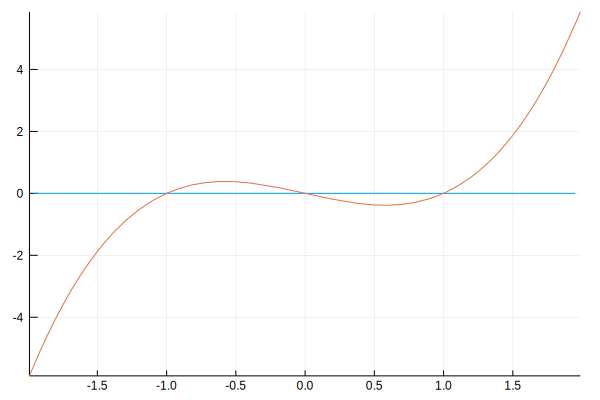

In [43]:
plot(x->0,-2,2, legend=false)
plot!(y->y*(y^2-1),-2,2, legend=false)

In [44]:
function bf!(fvec, x)
    fvec[1] = x[1]
    fvec[2] = x[2]*(x[2]^2-1)
end
nlsolve(bf!, [0.0, -2.4])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, -2.4]
 * Zero: [0.0, -1.0]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 8

We can also supply the Jacobian and the combined F and Jacobian manually, as to avoid finite differencing.

In [45]:
function bg!(x, gvec)
    gvec[1,1] = 1.0
    gvec[1,2] = 0.0
    gvec[2,1] = 0.0
    gvec[2,2] = 3x[2]^2-1
end

function bfg!(x, fvec, gvec)
    fvec[1] = x[1]
    x2squared = x[2]^2
    fvec[2] = x[2]*(x2squared-1)
    
    gvec[1,1] = 1.0
    gvec[1,2] = 0.0
    gvec[2,1] = 0.0
    gvec[2,2] = 3x2squared-1
    f
end
df = DifferentiableMultivariateFunction(bf!, bg!, bfg!)
nlsolve(df, [0.0, -2.4])

LoadError: [91mUndefVarError: DifferentiableMultivariateFunction not defined[39m

## Two methods
- Newton + trust region (default method)

```julia
    optimize(f, [g!, fg!], initial_x, method = :trust_region)
```
- Newton + linesearch (defaults to no linesearch)

```julia
    optimize(f, [g!, fg!], initial_x, method = :newton)
```

Not as finished as Optim, but there are several PRs currently active, that will improve the package significantly. We also need to unify interaces.

# Exercises

## Exercise: Hosaki (lessons from the workshop)

Plot the "Hosaki" problem from Optim.UnconstrainedProblems on $x\in[0,5]x[0,5]$

Initialize some different solvers of your own choice at the initial point given by the `initial_x` field of the problem instance. Do they converge to the same minimum?

Initialize the same solvers at x=[2.0,1.9], x=[2.0, 2.9], and one with a slight pertubation to x[1] (say x=[1.999999, 1.9] or x=[2.000001,1.9]). Can you explain the behavior given the plot from above?

Exercise: LineSearches

Based on the examples in UnconstrainedExamples, try to compare different line search choices. One possibility is to create a table the number of f, g!, and if applicable h! calls, time elapsed, and
final function value

## Exercise: LsqFit

Try generating data according from a model+noise setup as discussed above for a model of your own choice, and see if you can recover parameters.

Does changing the number of observations affect your results? Does it affect the estimated standard errors from `estimate_errors`?

## Exercise: NLsolve

Try finding a solution to the system of equations given by 
$$
\nabla f = 0
$$
where $\nabla f$ is the gradient from the Hosaki problem we looked at in the exercise above (note: remember the argument order)

By varying the initial point, are you able to recover the critical points we found earlier?